In [1]:
import numpy as np
import pandas as pd
# import sklearn.model_selection
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn import preprocessing
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.decomposition import PCA
import sklearn.decomposition

import pickle
#from IPython.core.display import HTML
#import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# from collections import OrderedDict
%matplotlib inline

<div class="span5 alert alert-info">
<h2>Notebook details</h2>

<p> This notebook is for <b>Clustering</b> for <b>Mortagage custome segementation</b> project.</p>
<p> The records are choosen by test and train. The loan amount is considerd as one feature. The salary and loan are used as amount</p>
<p> Notes.</p>
<ol>
<li>Apply K Mean clustering algorithm to the data</li>
<li>Apply methods to choose best value of K</li> 
    <ul>
     <li>The Elbow Sum-of-Squares Method</li>
     <li>The Silhouette Method </li>
    </ul>
<li>Consider K Mean as baseline analysis </li>
<li>Apply test train split to reduce data size to one million records</li>
        
</ol>
</div>

In [2]:
# setting some initial values and reading data from pickle file
# pd.set_option('display.max_colwidth', -1)
# css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
# cssAnalysis = '.analysis {background:#5bffc0; }' 
# HTML('<style>{} {}</style>'.format(css,cssAnalysis))
#pickle_file='df_selectdata_ML.sa'
pickle_file='df_selectdata_ML_WSA.sa'
df_selectdata = pickle.load( open( pickle_file, "rb" ) )
#df_final_months.info()
#df_final_months.head()

In [3]:
#df_selectdata.info()
len(df_selectdata)

31630026

## Helper methods

In [4]:
# To reduce the size of data set and allow the code to analyze cluster in each state the data frame filtered by State
def getDataFrameforState(inputframe,stateName='CA'):
    df=inputframe[inputframe.StateName==stateName]
    df=df[df.Accepted>0]
    df = df.reset_index()
    return df

In [5]:
# get K mean for no of cluster 
def getKmeansForCluster(noOfCluster, randomstate=1):
    kmean = KMeans(n_clusters=noOfCluster, random_state=randomstate)
    return kmean 

In [6]:
# get the fit predcit for k mean 
def getFitPredictForKMean(kMean):
    kmeans_val =kMean.fit_predict(x_cols)
    return kmeans_val

In [7]:
# get the data frame  with PCA with component dimension and K mean for 
#one component as all x cols and another component as the unique value
# this provides the clutser for each row in data frame 
def getPCADataFrame(noOfCluster,kmeans_val,componetNum=2):
    pca = PCA(n_components = componetNum)
    matrix = np.matrix(pca.fit_transform(x_cols))
    df_pca_matrix = pd.DataFrame(matrix)
    df_pca_matrix.columns = ['x','y']

    df_clusters = pd.DataFrame(df_filterdata.iloc[:,0])
    df_clusters['x'], df_clusters['y'] = df_pca_matrix['x'], df_pca_matrix['y']
    df_clusters['cluster_label'] = kmeans_val

    return df_clusters

In [9]:
# method to draw average silhouette score as graph for ranges of clusterand avg score calculated
def drawAverageSilhouetteScore(range_n_clusters,silhouette_avgscores):
        fig, axis = plt.subplots(1,1,figsize=(6,6),dpi=100)
        _ = plt.plot(range_n_clusters,silhouette_avgscores)
        _ = plt.xlabel('$K$')
        _ = plt.ylabel('Average Silhouette Score')
        _ = plt.title('Average Silhouette Scores for KMeans clustering')

In [10]:
# draw bar graph for number of rows for each cluster X axis(cluster number), Y axis(no of rows in each cluster)
def drawClusterBar(noOfCluster,kmeans_val):
    cluster_kmeans_val = pd.Series(kmeans_val).value_counts().sort_index()
    #print(cluster_kmeans_val5)

    fig, axis = plt.subplots(1,1,figsize=(6,6),dpi=100)
    _ = cluster_kmeans_val.plot(kind='bar')
    _ = plt.ylabel('Number of Points')
    _ = plt.xlabel('Cluster')
    _ = plt.title('No of points for Clusters($K$ = '+str(noOfCluster)+')')

In [11]:
# draw cluster point on graph for each cluster . depends on data frame created PCA
def drawClusterPlot(df_clusters):
    axis = sns.lmplot(data=df_clusters, x='x', y='y', hue='cluster_label', 
                   fit_reg=False, legend=True, legend_out=True,size=10)
    _ = axis.set_axis_labels("Component 1", "Component 2")

In [12]:
# draw elbow plot to get the best component value for PCA
def drawElbowPCAplot():
    pca = sklearn.decomposition.PCA()
    pca.fit(x_cols)
    fig, axis = plt.subplots(1,1,figsize=(12,6),dpi=100)
    _ = plt.plot(pca.explained_variance_)
    _ = plt.xlabel('$K$')
    _ = plt.xticks(range(0,33,1))
    _ = plt.xlim([0,31])
    _ = plt.ylabel('Explained Variance')
    _ = plt.title('Elbow Plot')

In [14]:
def getAllcolNameforDataframe(df):
    for col in df:
        print(col)

In [15]:
def getFilterDatasetForRowCount(df,noofRows, samplesize=0.5):
    if(len(df)>noofRows):
        df1,df2=train_test_split(df, shuffle=True,train_size=samplesize,test_size=samplesize)
        if(len(df1)>noofRows):
            df=df1.iloc[:noofRows,:]
    else:
         df=(df1.append(df2,ignore_index=True)).iloc[:noofRows,:]
    
    return df

### Processing Starts

In [16]:
# 1 million rows extracted for state to process
noofRows=1000000
range_n_clusters = range(2,11)
df_filterdata=getFilterDatasetForRowCount(getDataFrameforState(df_selectdata,'CA'),noofRows)

In [17]:
# create common x for all further processing for all feature columns 
x_cols = np.matrix(df_filterdata.iloc[:,8:])

In [18]:
print(len(df_filterdata))
print (len(df_filterdata.index.unique()))
print(len(x_cols))

1000000
1000000
1000000


## K - Mean clustering

#### Elbow Method for K 
We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

In [19]:
# calculate the K means for range to find out best K value for elbow method
ss = []
for k in range_n_clusters:
    #kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans = getKmeansForCluster(k)
    kmeans.fit(x_cols)
    #print('k='+str(k))
    #print('inertia '+str(kmeans.inertia_))
    ss.append(kmeans.inertia_)

In [20]:
print(max(ss))
print(min(ss))

94045829963.75282
22919354137.4891


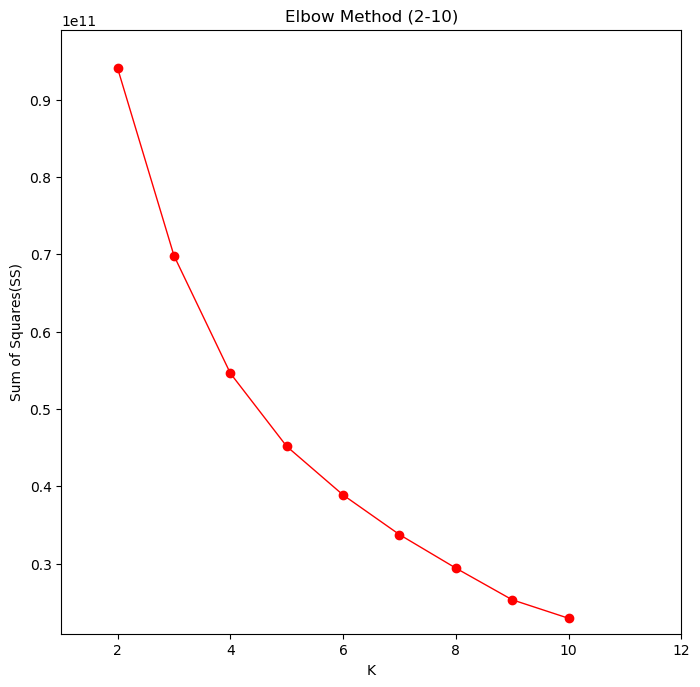

In [22]:
fig, axis = plt.subplots(1,1,figsize=(8,8),dpi=100)
_ = plt.plot(range_n_clusters, ss, 'ro-', linewidth = 1.0)
_ = plt.xlim([1,12])
_ = plt.xlabel('K')
_ = plt.ylim([20919354137,99045829963])
_ = plt.ylabel('Sum of Squares(SS)')
_ = plt.title('Elbow Method (2-10)')

#### Silhouette Method for K 
<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>

In [23]:

silhouette_avgscores = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster_labels = getFitPredictForKMean(getKmeansForCluster(n_clusters))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # The sample size is used to avoid memeory error
    silhouette_avg = silhouette_score(x_cols, cluster_labels,sample_size=50000)
    silhouette_avgscores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
# commented for memory issue
   # Create a subplot with 1 row and 2 columns

#     fig, ax1 = plt.subplots(1, 1)
#     _ = fig.set_size_inches(9, 7)

#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     _ = ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     _ = ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         #color = cm.spectral(float(i) / n_clusters)
#         color = plt.cm.Spectral(float(i) / n_clusters)
#         _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     _ = ax1.set_title(("The Silhouette plot for KMeans clustering with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
#     _ = ax1.set_xlabel("The silhouette coefficient values")
#     _ = ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     _ = ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

For n_clusters = 2 The average silhouette_score is : 0.7515476023930528
For n_clusters = 3 The average silhouette_score is : 0.5754422453290184
For n_clusters = 4 The average silhouette_score is : 0.529154518584007
For n_clusters = 5 The average silhouette_score is : 0.4738817231926336
For n_clusters = 6 The average silhouette_score is : 0.4740119863972071
For n_clusters = 7 The average silhouette_score is : 0.43692776554234886
For n_clusters = 8 The average silhouette_score is : 0.44033795207809495
For n_clusters = 9 The average silhouette_score is : 0.4373124518200059
For n_clusters = 10 The average silhouette_score is : 0.43570764027391407


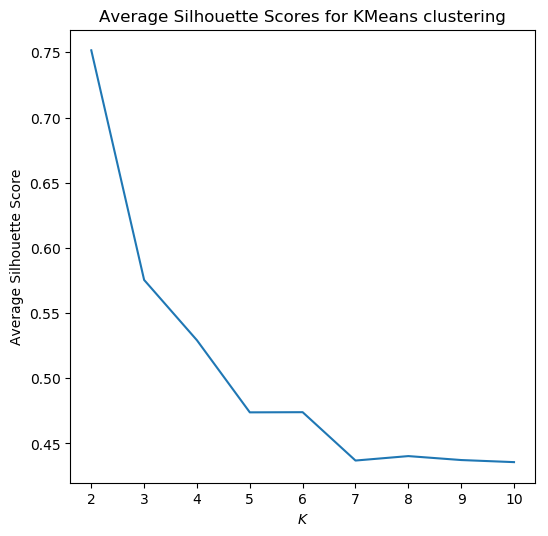

In [24]:
# draw graph for all above silhouette_score
drawAverageSilhouetteScore(range_n_clusters,silhouette_avgscores)

### Visualize cluster for range

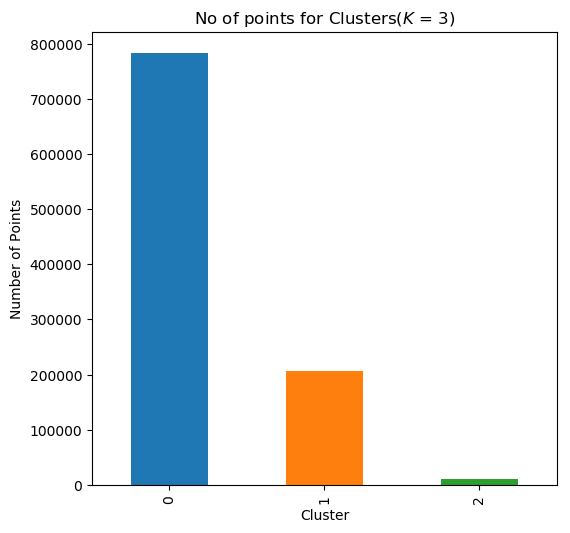

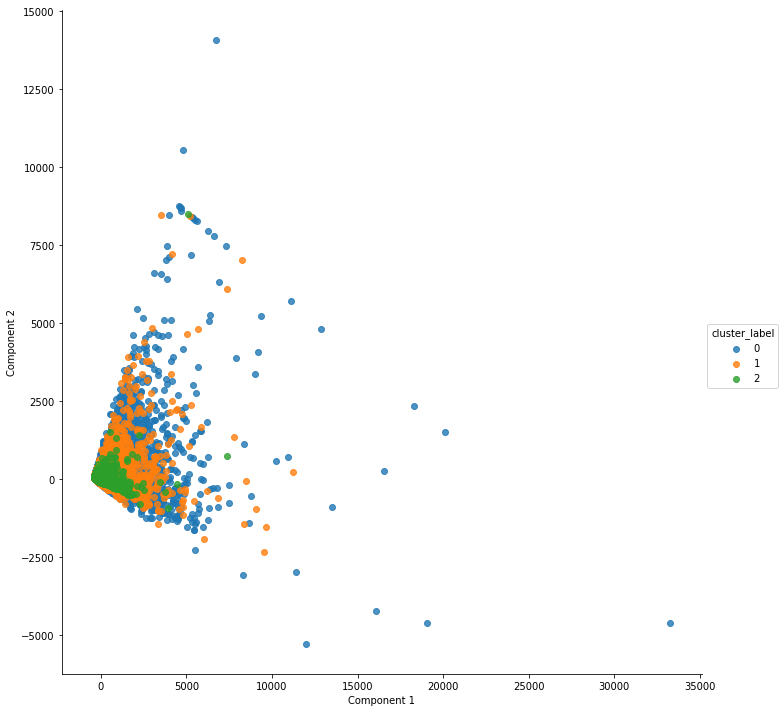

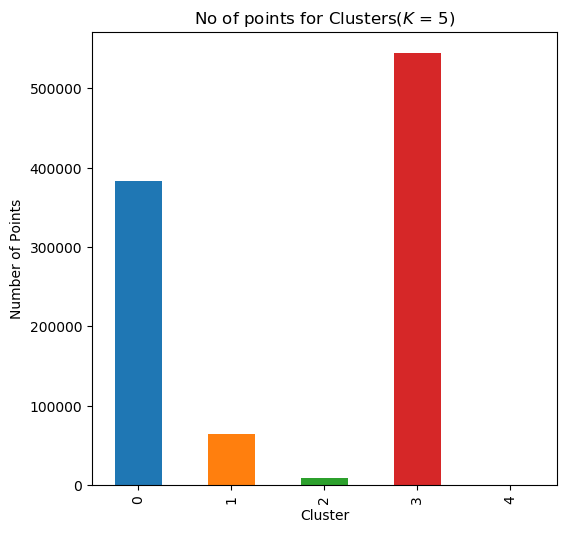

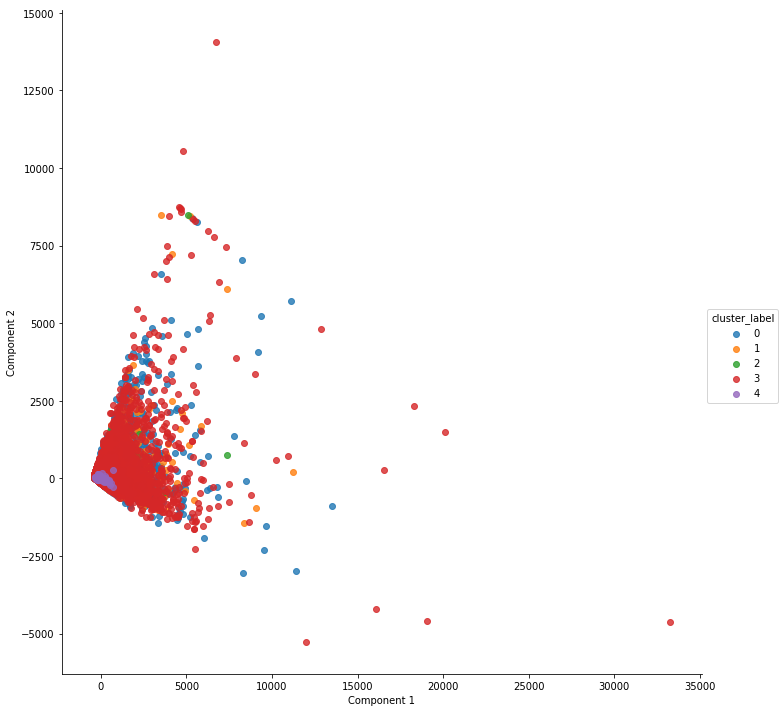

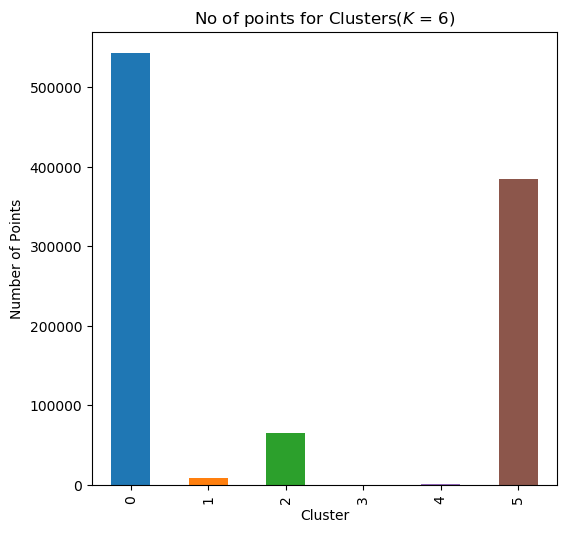

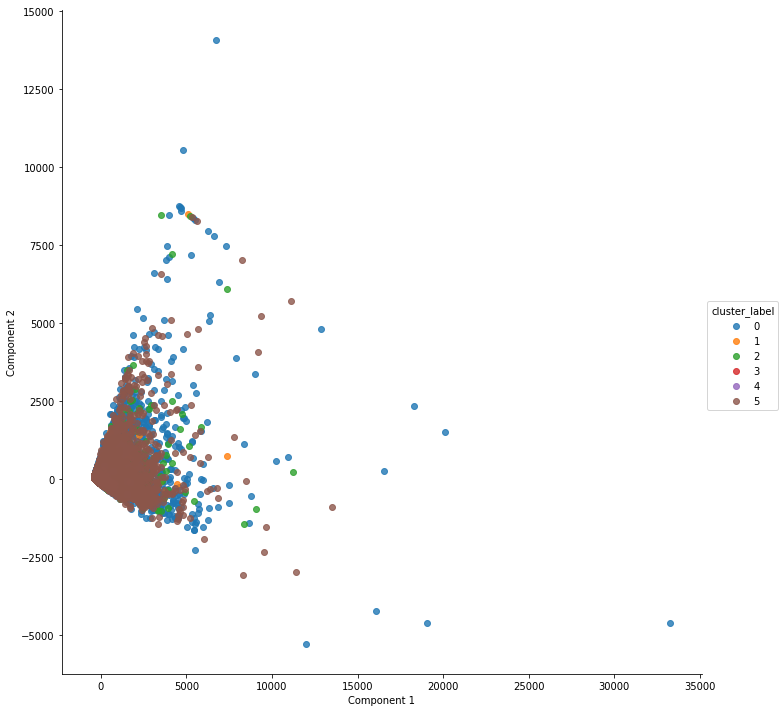

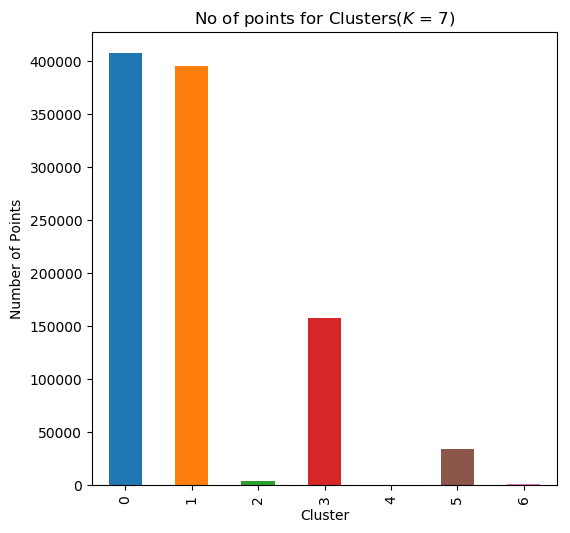

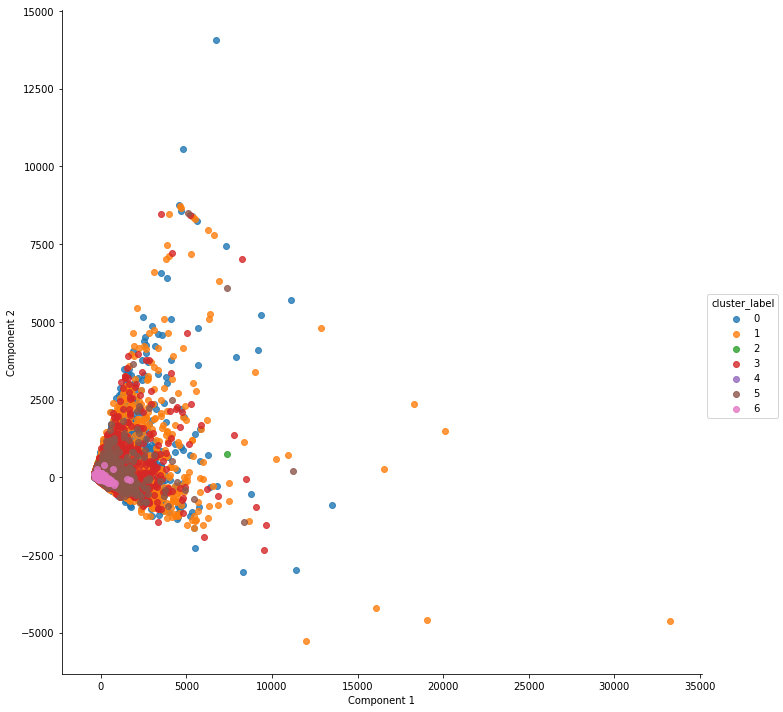

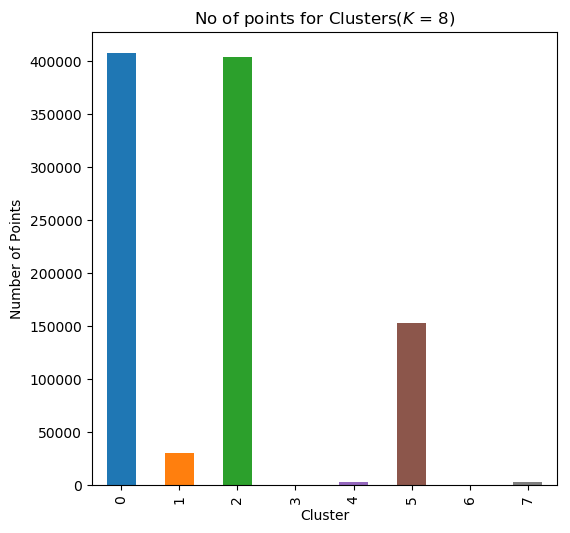

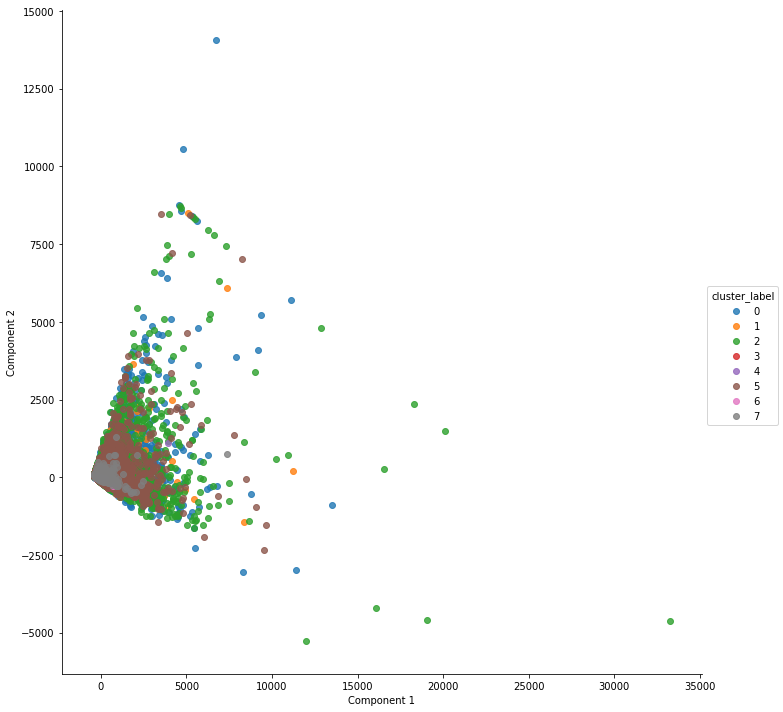

In [25]:
#range_n_clusters = range(2,11)
for noofcluster in [3,5,6,7,8]:#range_n_clusters:
    kmeans_val = getFitPredictForKMean(getKmeansForCluster(noofcluster))
    drawClusterBar(noofcluster,kmeans_val)
    drawClusterPlot(getPCADataFrame(noofcluster,kmeans_val))

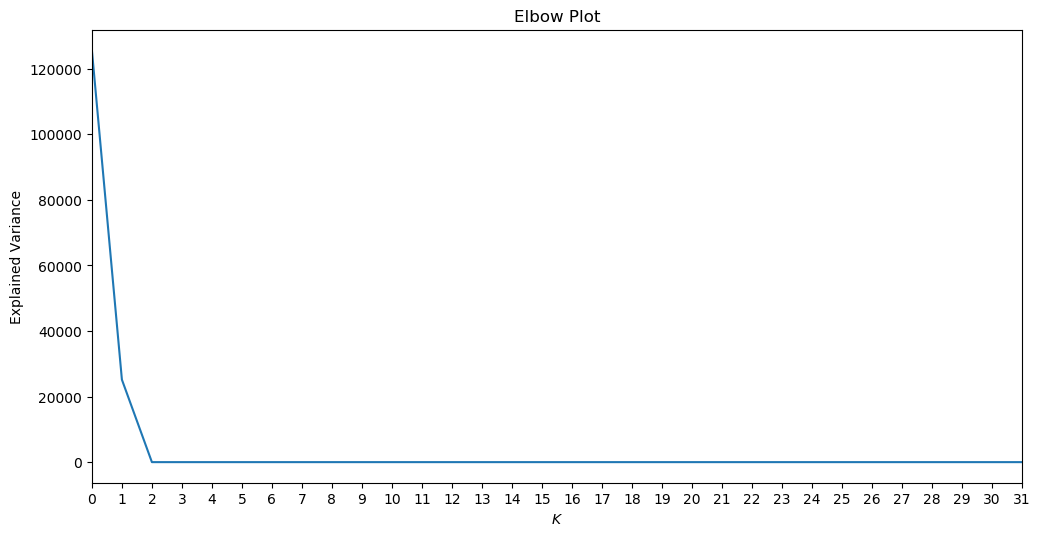

In [26]:
drawElbowPCAplot()

### Choose the best Kmean and display the data frame with cluster

In [ ]:
noofcluster=3
kmeans_val = getFitPredictForKMean(getKmeansForCluster(noofcluster))
drawClusterBar(noofcluster,kmeans_val)
drawClusterPlot(getPCADataFrame(noofcluster,kmeans_val))

In [ ]:
### Rough work below